## Part 1

### Loading the datasets
#### 1. Confirmed URL : https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv
#### 2. Deaths URL: https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv
#### 3. Recovered URL: https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv

#### Starting date on all three datasets is 22/01/2020

Steps (Without BeautifulSoup):-
1. Import the CSV 
2. Check if the last column title matches with the last date row in the cleaned dataset.
3. If it matches, don't add it to the dataset. 
4. If it does not match, go back iteratively until it matches and save all of the data.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
import requests
from bs4 import BeautifulSoup
from datetime import date
today = date.today()

Using TensorFlow backend.


In [2]:
confirmed_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
deaths_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
recovered_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"

In [3]:
d1 = today.strftime("%m/%d/%y").replace(' 0', ' ')
if(d1[0] == '0'):
    d1 = d1[1:]
d1

'6/06/20'

### Function to get the number of confirmed cases as a Dataframe

In [4]:
def get_confirmed():
    con_casesnew = pd.read_csv(confirmed_url)
    con_casesnew = con_casesnew.sum(axis=0)
    con_casesnew.drop(["Country/Region","Lat","Long"], axis=0, inplace=True)
    con_casesnew = pd.DataFrame(con_casesnew)
    con_casesnew.rename(columns={0: "Infected"}, inplace=True)
    return con_casesnew
get_confirmed()

,Infected
1/22/20,555
1/23/20,654
1/24/20,941
1/25/20,1434
1/26/20,2118
...,...
6/1/20,6265852
6/2/20,6378237
6/3/20,6508635
6/4/20,6632985


### Function to get the number of deaths as a Dataframe

In [5]:
def get_deaths():
    deaths_new = pd.read_csv(deaths_url)
    deaths_new = deaths_new.sum(axis=0)
    deaths_new.drop(["Country/Region","Lat","Long"], axis=0, inplace=True)
    deaths_new = pd.DataFrame(deaths_new)
    deaths_new.rename(columns={0: "Deaths"}, inplace=True)
    return deaths_new
get_deaths()

,Deaths
1/22/20,17
1/23/20,18
1/24/20,26
1/25/20,42
1/26/20,56
...,...
6/1/20,375543
6/2/20,380249
6/3/20,385947
6/4/20,391136


### Function to get the number of recoveries as a Dataframe

In [6]:
def get_recovered():
    rec_new = pd.read_csv(recovered_url)
    rec_new = rec_new.sum(axis=0)
    rec_new.drop(["Country/Region","Lat","Long"], axis=0, inplace=True)
    rec_new = pd.DataFrame(rec_new)
    rec_new.rename(columns={0: "Recovered"}, inplace=True)
    
    return rec_new
get_recovered()

,Recovered
1/22/20,28
1/23/20,30
1/24/20,36
1/25/20,39
1/26/20,52
...,...
6/1/20,2691038
6/2/20,2794375
6/3/20,2874125
6/4/20,2944289


### Scraper

In [7]:
def get_newvals():
    url_wminfo = "https://www.worldometers.info/coronavirus/"
    page = requests.get(url_wminfo)
    soup = BeautifulSoup(page.content, 'html.parser')
    result = soup.find_all("div", {"id":"maincounter-wrap"})
    numbers = []
    for r in result:
        numbers.append(int(r.text.split(':')[-1].replace(',','').replace(' ','')))
    return numbers

In [8]:
numbers = get_newvals()
numbers

[6862700, 398496, 3361577]

## Forecasting Confirmed Cases

In [9]:
df = get_confirmed()
df.tail()

,Infected
6/1/20,6265852
6/2/20,6378237
6/3/20,6508635
6/4/20,6632985
6/5/20,6734088


In [10]:
close_data = df['Infected'].values
close_data = close_data.reshape((-1,1))

split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

cclose = close_data

In [11]:
look_back = 2

train_generator = TimeseriesGenerator(cclose, cclose, length=look_back, batch_size=20)     
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [12]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(
    LSTM(10,
        activation='relu',
        input_shape=(look_back,1))
)
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

num_epochs = 100
model.fit_generator(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/100
7/7 [==============================] - 4s 579ms/step - loss: 8741307452575.2832
Epoch 2/100
7/7 [==============================] - 0s 45ms/step - loss: 8717084957931.7012
Epoch 3/100
7/7 [==============================] - 0s 50ms/step - loss: 8673864158385.6719
Epoch 4/100
7/7 [==============================] - 0s 39ms/step - loss: 8644456838677.7314
Epoch 5/100
7/7 [==============================] - 0s 26ms/step - loss: 8612677025596.6562
Epoch 6/100
7/7 [==============================] - 0s 34ms/step - loss: 8586467684961.6719
Epoch 7/100
7/7 [==============================] - 0s 27ms/step - loss: 8544865347460.7764
Epoch 8/100
7/7 [==============================] - 0s 41ms/step - loss: 8509461164400.5967
Epoch 9/100
7/7 [==============================] - 0s 27ms/step - loss: 8463283241770.5078
Epoch 10/100
7/7 [==============================] - 0s 35ms/step - loss: 8424766253920.7168
Epoch 11/100
7/7 [==============================] - 0s 24ms/step - loss: 8391263882298.5

7/7 [==============================] - 0s 45ms/step - loss: 1593782654265.7314
Epoch 91/100
7/7 [==============================] - 0s 39ms/step - loss: 1507079767833.7910
Epoch 92/100
7/7 [==============================] - 0s 41ms/step - loss: 1460033149180.9851
Epoch 93/100
7/7 [==============================] - 0s 46ms/step - loss: 1393056941398.8955
Epoch 94/100
7/7 [==============================] - 0s 39ms/step - loss: 1299440046970.2837
Epoch 95/100
7/7 [==============================] - 0s 40ms/step - loss: 1235341683618.1492
Epoch 96/100
7/7 [==============================] - 0s 46ms/step - loss: 1164995276448.8208
Epoch 97/100
7/7 [==============================] - 0s 36ms/step - loss: 1118648609716.3882
Epoch 98/100
7/7 [==============================] - 0s 60ms/step - loss: 1060869867405.6119
Epoch 99/100
7/7 [==============================] - 1s 72ms/step - loss: 986207455597.0597
Epoch 100/100
7/7 [==============================] - 0s 53ms/step - loss: 924531876701.8059


In [13]:
prediction = model.predict_generator(test_generator)

cclose = cclose.reshape((-1))
close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

In [14]:
close_data = close_data.reshape((-1))

def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
num_prediction = 1
forecast = predict(num_prediction, model)
forecast = numbers[0]

In [15]:
forecast

6862700

In [16]:
df.tail()

,Infected
6/1/20,6265852
6/2/20,6378237
6/3/20,6508635
6/4/20,6632985
6/5/20,6734088


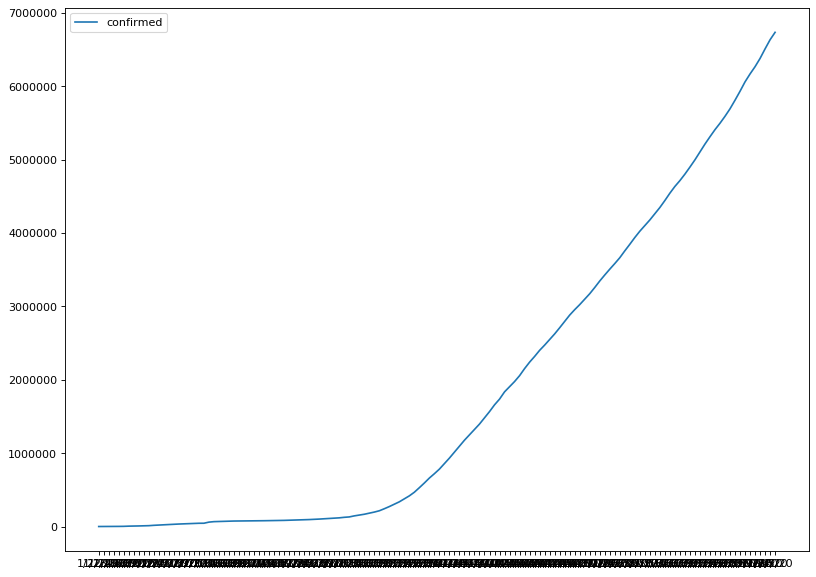

In [17]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df, label='confirmed')
plt.legend(loc="upper left")

In [18]:
df_temp = df
df_temp.loc[d1] = forecast
df_temp

,Infected
1/22/20,555
1/23/20,654
1/24/20,941
1/25/20,1434
1/26/20,2118
...,...
6/2/20,6378237
6/3/20,6508635
6/4/20,6632985
6/5/20,6734088


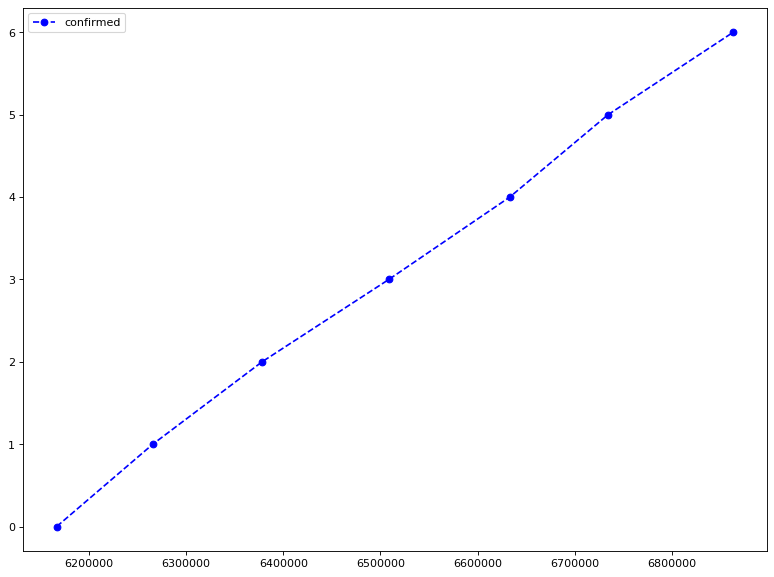

In [19]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12,9), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_temp[-7:], range(7), linestyle='--', marker='o', color='b', label='confirmed')
plt.legend(loc="upper left")

## Forecasting Recoveries

In [20]:
df_rec = get_recovered()
df_rec.tail()

,Recovered
6/1/20,2691038
6/2/20,2794375
6/3/20,2874125
6/4/20,2944289
6/5/20,2746192


In [21]:
close_data_rec = df_rec['Recovered'].values
close_data_rec = close_data.reshape((-1,1))

split_percent = 0.80
split = int(split_percent*len(close_data_rec))

close_train_rec = close_data_rec[:split]
close_test_rec = close_data_rec[split:]

cclose_rec = close_data_rec

In [22]:
look_back = 2

train_generator_rec = TimeseriesGenerator(cclose_rec, cclose_rec, length=look_back, batch_size=20)     
test_generator_rec = TimeseriesGenerator(close_test_rec, close_test_rec, length=look_back, batch_size=1)

In [23]:
prediction_rec = model.predict_generator(test_generator_rec)

cclose_rec = cclose_rec.reshape((-1))
close_train_rec = close_train_rec.reshape((-1))
close_test_rec = close_test_rec.reshape((-1))
prediction_rec = prediction_rec.reshape((-1))

In [24]:
close_data_rec = close_data_rec.reshape((-1))

def predict(num_prediction, model):
    prediction_list = close_data_rec[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
num_prediction = 1
forecast_rec = predict(num_prediction, model)
forecast_rec = numbers[2]

In [25]:
forecast_rec

3361577

In [26]:
df_rec.tail()

,Recovered
6/1/20,2691038
6/2/20,2794375
6/3/20,2874125
6/4/20,2944289
6/5/20,2746192


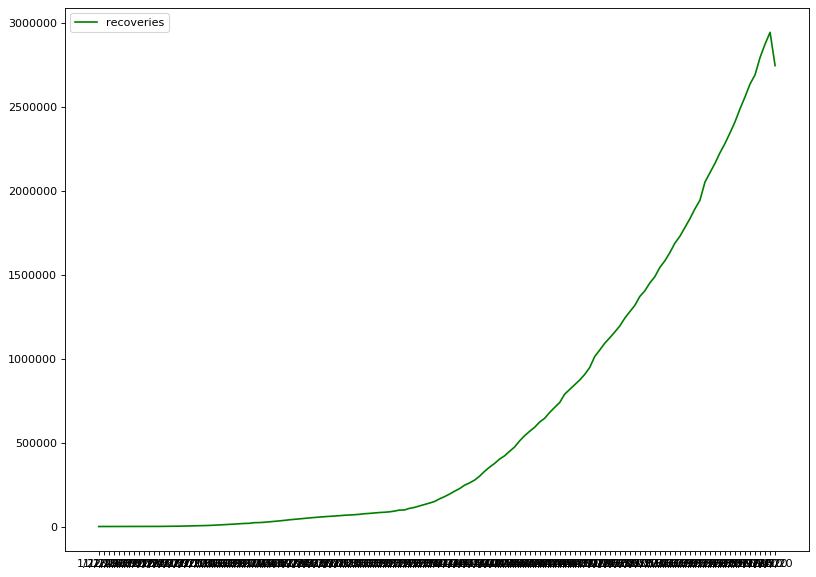

In [27]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_rec, color='g', label='recoveries')
plt.legend(loc="upper left")

In [28]:
df_temp_rec = df_rec
df_temp_rec.loc[d1] = forecast_rec
df_temp_rec

,Recovered
1/22/20,28
1/23/20,30
1/24/20,36
1/25/20,39
1/26/20,52
...,...
6/2/20,2794375
6/3/20,2874125
6/4/20,2944289
6/5/20,2746192


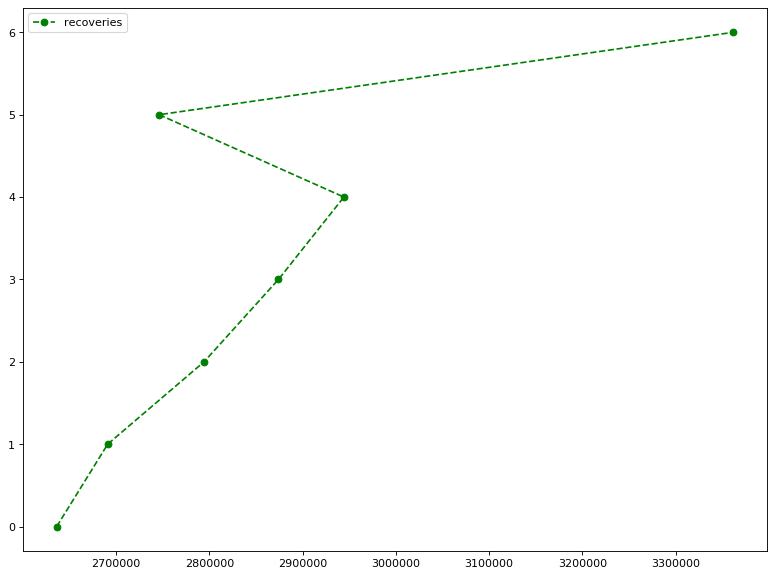

In [29]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12,9), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_temp_rec[-7:], range(7), linestyle='--', marker='o', color='g', label='recoveries')
plt.legend(loc="upper left")

## Forecasting Deaths

In [30]:
df_dea = get_deaths()
df_dea.tail()

,Deaths
6/1/20,375543
6/2/20,380249
6/3/20,385947
6/4/20,391136
6/5/20,394875


In [31]:
close_data_dea = df_dea['Deaths'].values
close_data_dea = close_data_dea.reshape((-1,1))

split_percent = 0.80
split = int(split_percent*len(close_data_dea))

close_train_dea = close_data_dea[:split]
close_test_dea = close_data_dea[split:]

cclose_dea = close_data_dea

In [32]:
look_back = 2

train_generator_dea = TimeseriesGenerator(cclose_dea, cclose_dea, length=look_back, batch_size=20)     
test_generator_dea = TimeseriesGenerator(close_test_dea, close_test_dea, length=look_back, batch_size=1)

In [33]:
prediction_dea = model.predict_generator(test_generator_dea)

cclose_dea = cclose_dea.reshape((-1))
close_train_dea = close_train_dea.reshape((-1))
close_test_dea = close_test_dea.reshape((-1))
prediction_dea = prediction_dea.reshape((-1))

In [34]:
close_data_dea = close_data_dea.reshape((-1))

def predict(num_prediction, model):
    prediction_list = close_data_dea[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
num_prediction = 1
forecast_dea = predict(num_prediction, model)
forecast_dea = numbers[1]

In [35]:
forecast_dea

398496

In [36]:
df_dea.tail()

,Deaths
6/1/20,375543
6/2/20,380249
6/3/20,385947
6/4/20,391136
6/5/20,394875


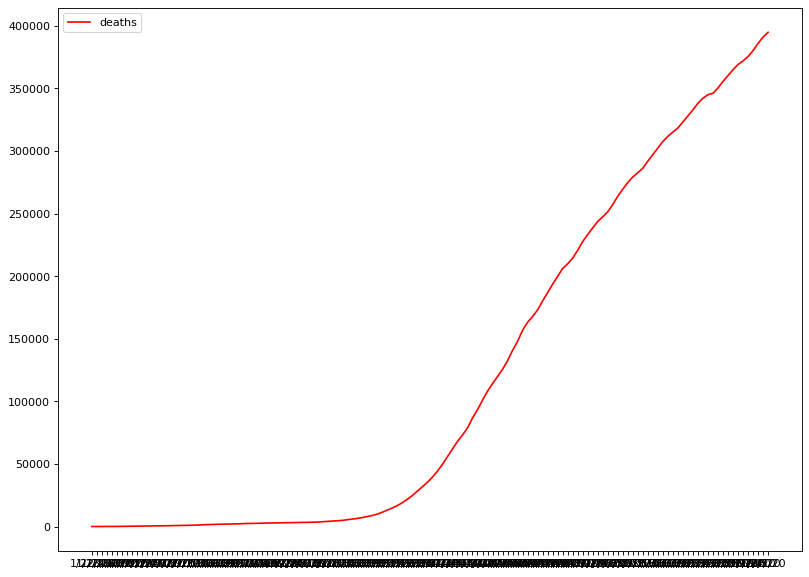

In [37]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_dea, color='r', label='deaths')
plt.legend(loc="upper left")

In [38]:
df_temp_dea = df_dea
df_temp_dea.loc[d1] = forecast_dea
df_temp_dea

,Deaths
1/22/20,17
1/23/20,18
1/24/20,26
1/25/20,42
1/26/20,56
...,...
6/2/20,380249
6/3/20,385947
6/4/20,391136
6/5/20,394875


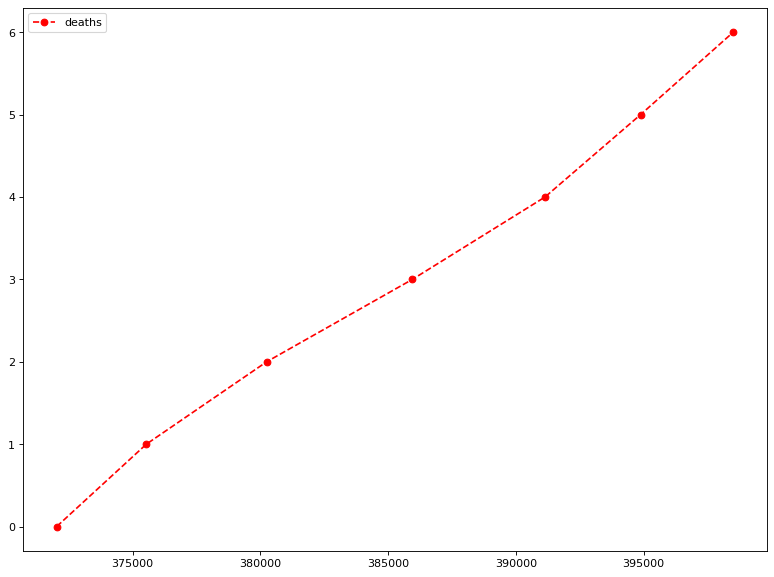

In [39]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12,9), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_temp_dea[-7:], range(7), linestyle='--', marker='o', color='r', label='deaths')
plt.legend(loc="upper left")